## Deep Learning on Satellite Images

* While we continue on our goal of creating a model to predict GDP of a country using Satellite Images, first thing we do is to build baseline models. 
  - We will use these baseline models as reference points to compare our final model to

* Goal of this notebook is to document creation and evaluation of baseline models
* We will try to build 
  - Mean Prediction model
  - Deep Learning model

* After creating the models we will graphically look at how well the model is performing on the Test set


Firstly let's load the required libraries.

In [ ]:
import matplotlib.pyplot as plt
import pathlib

### Downloading Dataset

Below we basically setup kaggle to be able to load the required dataset using kaggle cli.

Follow [this](https://www.kaggle.com/general/51898) to get your own username and kaggle key 

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "abhijeetdtu"
os.environ['KAGGLE_KEY'] = ""

Let's download the dataset from [here](https://kaggle.com/abhijeetdtu/country-nightlight-dataset)

In [ ]:
!kaggle datasets download -d abhijeetdtu/country-nightlight-dataset

 99% 682M/685M [00:06<00:00, 140MB/s]
100% 685M/685M [00:06<00:00, 109MB/s]


Now we unzip the dataset

In [ ]:
import zipfile

In [ ]:
if not os.path.exists("dataset"):
  for file in os.listdir():
    if file.find(".zip") > -1:
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

Now let's git clone our helper code

In [ ]:
!git clone https://github.com/abhijeetdtu/dsba4152

Cloning into 'dsba4152'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 105 (delta 23), reused 100 (delta 18), pack-reused 0
Receiving objects: 100% (105/105), 9.70 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
%ls

country-nightlight-dataset.zip  dsba4152/       sample_data/
dataset/                        gdp_melted.csv


In [ ]:
%cd dsba4152

/content/dsba4152


In [ ]:
#if you need lastest code
#!git fetch origin master

In [ ]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
from dsba4152.utils.get_test_train import GetTestTrain

### Data Load and Preprocessing

Let's setup the root path where our dataset of images is and where our csv which has our y labels.

Then we use our helper function we just imported to load all the images and their corresponding labels. The helper method also returns other metadata including `year` of the image and `country code` of the image as well. This information is used later on.

In [ ]:
root_path = "../dataset/dataset/"
csv_path = "../gdp_melted.csv"
X , y , years , code = GetTestTrain(root_path , csv_path , resize=True).get_all_data()

Let's look at a few images we have just loaded.

In [ ]:
imgdf = pd.DataFrame({ "gdp" : y , "year" : years}).reset_index()
imgdf["year"].unique()

array([1993, 2009, 2000, 1998, 2002, 1997, 2001, 2011, 2010, 1999, 2005,
       2007, 1992, 2003, 1996, 2006, 2004, 2008])

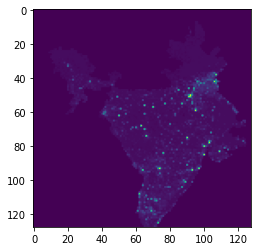

In [ ]:
plt.imshow(X[imgdf[imgdf["year"] == 2006].head(1)["index"].values[0]])

## Trick and Treat !

Okay so here is something different that we are going to try before we throw the data into the model. 

Even though deep learning models do feature extraction, but if we think we can help why not ?

The idea we are going to follow is

1. Select a base reference image , possibly from one of the earliest years (1993)
2. Divide the intensities of the reference image into bins
3. Bin every other image based on the bins obtained from the reference image
4. After binning the image, we keep values that are above a threshold (that we find using hit and try)

What this helps us achieve is - make all images relative to the base image. This in turn helps the model in determining which image is brighter than the base image and therefore help with the predictions. 

Let's look at 3 images, each being a decade apart from the previous one.

In [ ]:
im1993 = X[imgdf[imgdf["year"] == 1993].head(1)["index"].values[0]]
im2003 = X[imgdf[imgdf["year"] == 2003].head(1)["index"].values[0]]
im2011 = X[imgdf[imgdf["year"] == 2011].head(1)["index"].values[0]]

refyear = imgdf["year"].unique()[0]
refimg = X[imgdf[imgdf["year"] == refyear].head(1)["index"].values[0]]
space =  np.geomspace(0.5,1,1000)
bins = np.quantile(refimg ,space)

def thresh(im , t=970):
    g = np.digitize(im , bins)
    return (g > t)

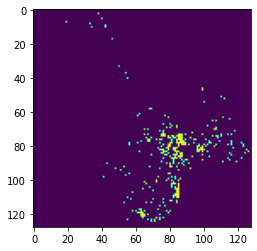

In [ ]:
plt.imshow(thresh(im1993))

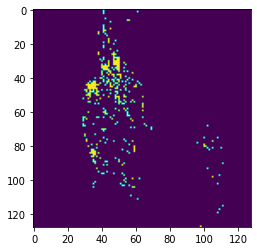

In [ ]:
plt.imshow(thresh(im2003))

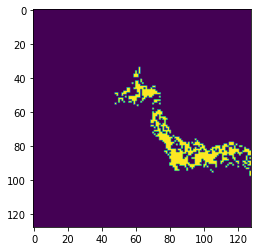

In [ ]:
plt.imshow(thresh(im2011))

Let's apply the trick to all our images.

Another thing that we have to do is to add a new axis to our image dataset because `Keras` expects input data to be in a specific format - (batch_size , height , width , number_of channels).

Since we have only one channel, simply using `np.newaxis` helps.

In [ ]:
import cv2

#X50 = np.array([cv2.resize(im ,(128,128) ,cv2.INTER_CUBIC) for im in X])
X50 = X.copy()
X50 = X50[..., np.newaxis]
X50 = thresh(X50)

input_shape = X50.shape
input_shape

(2667, 128, 128, 1)

Let's split the data.

One thing that we take care of here is to `stratify`. This is because we want our training and testing data to have similar number of images belonging to each year.


In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train, y_test = train_test_split(X50 , y , stratify = years)

In [ ]:
train_idx = y_train.index
test_idx = y_test.index
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [ ]:
np.mean(y_train)

1503935922402.557

In [ ]:
np.median(y_train)

820382000000.0

Below we scale the `gdp` values. This is crucial because it pushes everything to a managable range which prevents the gradient in the neural network from becoming too small or too large ([vanishing or exploding gradient problem](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/))

In [ ]:
ss = StandardScaler()
y_train = ss.fit_transform(y_train)
y_test = ss.transform(y_test)

## Let's get funky!

Now that we have everything setup! Let's get to modeling.

First let's import `Keras` and build up a `CNN`


In [ ]:
from keras.models import Sequential
from keras.layers import Dense , MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv2D
import keras.backend as K
from keras.metrics import RootMeanSquaredError
from keras import layers
import keras

In [ ]:
def build_model(input_shape):
    def model():
        model = Sequential()
        model.add(Conv2D(128, 3, activation='relu', input_shape=input_shape[1:]))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(64
                                , kernel_size=3
                                , strides=2
                                , padding="same"
                                , kernel_regularizer=keras.regularizers.L1(0.05)))
        model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(128
                                , kernel_size=3
                                , strides=2
                                , padding="same"
                                , kernel_regularizer=keras.regularizers.L1(0.05)))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))
        model.add(layers.Conv2D(256
                                , kernel_size=3
                                , strides=2
                                , padding="same"
                                , kernel_regularizer=keras.regularizers.L1(0.05)))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(Flatten())
        model.add(Dense(1, kernel_initializer='normal', activation="linear"))

        model.compile(loss="log_cosh",metrics=[RootMeanSquaredError(name='rmse')], optimizer='adam')
        return model
    return model


We wrap our Keras model into `sklearn` API which allows us to use the model with sklearn features like `cross_validate` if we want to.

In [ ]:
build_model(input_shape)().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        73792     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0

In [ ]:
estimator = KerasRegressor(build_fn=build_model(input_shape), epochs=5000, verbose=0)

In [ ]:
# from sklearn.model_selection import cross_validate

# cross_validate(estimator, X50 , y)

Let's train the model

In [ ]:
estimator.fit(X_train , y_train ,epochs=100 , verbose=2)

Epoch 1/500
63/63 - 6s - loss: 321.9100 - rmse: 9.0389
Epoch 2/500
63/63 - 6s - loss: 68.0828 - rmse: 5.3837
Epoch 3/500
63/63 - 6s - loss: 29.7852 - rmse: 6.6811
Epoch 4/500
63/63 - 6s - loss: 24.0563 - rmse: 6.9091
Epoch 5/500
63/63 - 6s - loss: 22.2524 - rmse: 7.8884
Epoch 6/500
63/63 - 6s - loss: 20.5251 - rmse: 4.6114
Epoch 7/500
63/63 - 6s - loss: 18.0071 - rmse: 3.7037
Epoch 8/500
63/63 - 6s - loss: 13.7363 - rmse: 3.3420
Epoch 9/500
63/63 - 6s - loss: 13.7215 - rmse: 4.3733
Epoch 10/500
63/63 - 6s - loss: 12.5878 - rmse: 3.7523
Epoch 11/500
63/63 - 6s - loss: 4.3052 - rmse: 1.0196
Epoch 12/500
63/63 - 6s - loss: 2.1702 - rmse: 0.7925
Epoch 13/500
63/63 - 6s - loss: 1.9209 - rmse: 0.6756
Epoch 14/500
63/63 - 6s - loss: 1.9014 - rmse: 0.6262
Epoch 15/500
63/63 - 6s - loss: 1.9171 - rmse: 0.6092
Epoch 16/500
63/63 - 6s - loss: 1.9511 - rmse: 0.6093
Epoch 17/500
63/63 - 6s - loss: 1.9693 - rmse: 0.5845
Epoch 18/500
63/63 - 6s - loss: 2.0067 - rmse: 0.5857
Epoch 19/500
63/63 - 6s - 

KeyboardInterrupt: ignored

### Visualizing the learnt filters

Before we look at how well our model is performing, what has our model learnt really ? 

We can get a glimpse of that by peaking into the filters that the model has learnt.

Let's look at the `3rd Conv2d` layer filters


In [ ]:
filters, biases = estimator.model.layers[12].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
filters.shape

(3, 3, 128, 256)

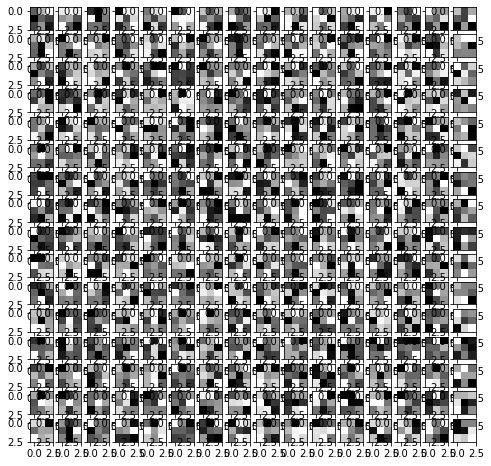

In [ ]:
n_filters, ix = filters.shape[-1], 1
r , c = 16,16
fig , axs = plt.subplots(r,c, figsize=(8,8))
fig.set
for i in range(n_filters):
  # get the filter
  f = filters[:, :, 0, i]
  ax = axs[int(i/c)][i%c]
  # plot filter channel in grayscale
  ax.imshow(f[:, :], cmap='gray')
	
plt.show()

It seems like the model is learning filters that are separating out lit up regions from the darker/unlit regions. 


### Feature Map visualization

Now that we have looked at the learnt filters, let's look at the activations for a particular input image. This would give a sense of what exactly the model is focusing on to make the predictions.

In [ ]:
from keras.models import Model
feature_model = Model(inputs=estimator.model.inputs, outputs=estimator.model.layers[12].output)

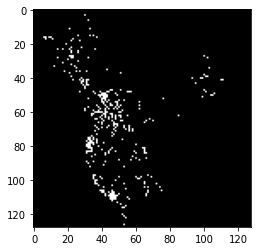

In [ ]:
img = np.expand_dims(X50[400], axis=0)
plt.imshow(img[0,  : , : , 0] , cmap='gray')

In [ ]:
feature_maps = feature_model.predict(img)
feature_maps.shape

(1, 16, 16, 256)

IndexError: ignored

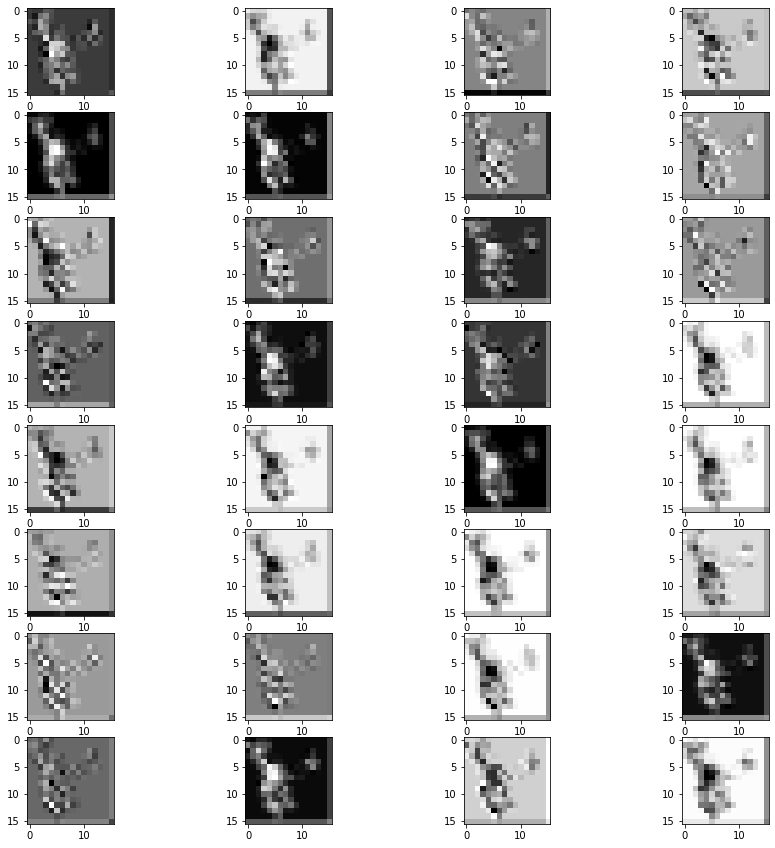

In [ ]:
n_filters, ix = feature_maps.shape[-1], 1
fig , axs = plt.subplots(8,4, figsize=(15,15))
fig.set
for i in range(n_filters):
  # get the filter
  f = feature_maps[0, :, :, i]
  ax = axs[int(i/4)][i%4]
  # plot filter channel in grayscale
  ax.imshow(f, cmap='gray')
	
plt.show()

Looking at some of the feature maps we can see that the activations are happening in the lit up regions. 

Interestingly one of the feature map appears to be segmenting the country out of the image.

Now that we have visually looked at how our model is working, let's quantitatively evaluate the performance.

### Error Metrics and Comparisions

We will use `RMSE` below on the `train` and `test` sets to evaluate the performance.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
def mae_ru(y_true , y_pred):
  y_true = ss.inverse_transform(y_true)
  y_pred = ss.inverse_transform(y_pred)
  return mean_absolute_error(y_true,y_pred)

In [ ]:
def rmse_ru(y_true, y_pred):
  y_true = ss.inverse_transform(y_true)
  y_pred = ss.inverse_transform(y_pred)
  return np.sqrt(mean_squared_error(y_true,y_pred))

In [ ]:
mae_ru(y_train , estimator.predict(X_train))

468695276558.962

In [ ]:
rmse_ru(y_train , estimator.predict(X_train))

673473623647.0739

Train set RMSE - $138B

In [ ]:
mae_ru(y_test , estimator.predict(X_test))

491954867181.8636

In [ ]:
rmse_ru(y_test , estimator.predict(X_test))

700783068056.2545

Test Set RMSE - $572B

In [ ]:
max_gdp = ss.inverse_transform(np.max(y_test).reshape(-1,1))[0][0]
max_gdp

7551500000000.0

In [ ]:
mean_gdp = ss.inverse_transform(np.mean(y_test).reshape(-1,1))[0][0]
mean_gdp

1424757109708.1125

### Mean Predictor Performance

Now let's compare our model with a very simple `Mean/Median` Predictor.

In [ ]:
rmse_ru(y_train , np.repeat(np.median(y) , y_train.shape[0]))

1.337204780702327e+24

In [ ]:
rmse_ru(y_train , np.repeat(np.mean(y) , y_train.shape[0]))

2.537058027822039e+24

`1e+24` that's very poor performance! Our `CNN` model does so much better!

In [ ]:
rmse_ru(y_test , estimator.predict(X_test)) / max_gdp

0.09280051222356546

In [ ]:
rmse_ru(y_test , estimator.predict(X_test)) / mean_gdp

0.4918614290683011

### Model Debugging

To further improve our model we need to first figure out where it's performing poorly.

Few areas that we want to do a deeper dive on are
1. Compression
  - Since we are resizing the images, larger countries undergo larger compression which might potentially lead to poorer performance for these countries
2. Years
  - It is also possible that since more recent images are brighter than image, say from 1993 , we might see poor performance on those early years and therefore might want to investigate the results.


To visually look into these 2 areas, we do a scatter plot of the `predicted` values vs the `ground truth` and `fill` depending on either the `compression` or `years`.

First let's get the compression values for each country.

In [ ]:
size_df  =pd.DataFrame([(f.split("_")[0] , f) for f in os.listdir(root_path)] , columns=["code" , "path"]).drop_duplicates("code")

def getshape(p):
  s = plt.imread(root_path + p).shape
  return np.array(s)

shapes = size_df["path"].apply(getshape)

In [ ]:
size_df[["hc" , "wc"]] = np.array(list(shapes.values)) / 128

In [ ]:
size_df

,code,path,hc,wc
0,CHN,CHN_2000.png_0_8068.jpeg,34.234375,61.757812
1,RUS,RUS_1993.png_0_3204.jpeg,36.031250,337.507812
2,JPN,JPN_1998.png_0_5932.jpeg,18.695312,25.750000
4,BRA,BRA_2002.png_0_9045.jpeg,39.664062,38.429688
6,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688
7,IND,IND_2002.png_0_1738.jpeg,28.851562,29.664062
13,BGD,BGD_2006.png_0_7634.jpeg,6.101562,5.570312
22,MEX,MEX_2005.png_0_879.jpeg,17.796875,29.687500


We can see that larger countries like `Russia` experience huge compression, specially on its width. Whereas smaller countries like 'Bangladesh' experience relatively smaller compression.

In [ ]:
y_size_df = pd.DataFrame({"code" : code}).set_index("code").join(size_df.set_index("code")).reset_index()
y_size_df["compfactor"] = y_size_df["hc"] + y_size_df["wc"] 
y_size_df

,code,path,hc,wc,compfactor
0,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688,75.750000
1,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688,75.750000
2,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688,75.750000
3,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688,75.750000
4,AUS,AUS_1998.png_0_4798.jpeg,32.445312,43.304688,75.750000
...,...,...,...,...,...
2662,RUS,RUS_1993.png_0_3204.jpeg,36.031250,337.507812,373.539062
2663,RUS,RUS_1993.png_0_3204.jpeg,36.031250,337.507812,373.539062
2664,RUS,RUS_1993.png_0_3204.jpeg,36.031250,337.507812,373.539062
2665,RUS,RUS_1993.png_0_3204.jpeg,36.031250,337.507812,373.539062


In [ ]:
from plotnine import *

mt = theme(panel_grid_major=element_line(alpha=0.2 , color="#3d405b") 
          , panel_grid_minor=element_blank() 
          , panel_background=element_rect(fill="#f4f1de"))

In [ ]:
def plotcomp(X,y,comp):
  perfdf = pd.DataFrame({"ytrue" : ss.inverse_transform(y)[:, 0] 
                       , "ypred" :  ss.inverse_transform(estimator.predict(X).reshape(-1,1))[:,0] 
                       ,"comp" : comp})
  
  p = (
    ggplot(perfdf , aes(x="ytrue" , y="ypred" , fill="comp")) 
    + geom_point(stroke=0 , alpha=0.8)
    + annotate('segment',x=0,y=0,xend= 7e12 , yend=7e12 , alpha=0.2)
    + scale_y_continuous(breaks=np.arange(500e9 , 10e12, 2e12) , labels=[f"{v}T" for v in np.arange(0.5, 10 , 2)])
    + scale_x_continuous(breaks=np.arange(500e9 , 10e12, 2e12) , labels=[f"{v}T" for v in np.arange(0.5, 10 , 2)])
  )
  return p + mt

def plot(X,y,idx):
  comp = y_size_df.iloc[idx , :]["compfactor"]
  return plotcomp(X,y,comp)
  

Let's first look at how compression effects our predictions on the `training` set.

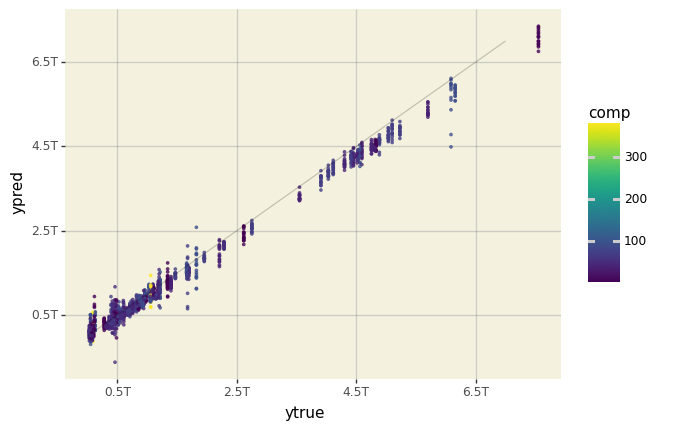

<ggplot: (-9223363282193542761)>

In [ ]:
plot(X_train,y_train , train_idx)

Red flag! Red flag! 

We are seeing perfectly aligned predictions and ground truths for our training set, which indicates that our model might be overfitting the training set. Therefore one thing we will follow up on is to reduce this overfitting.

Now let's look at the test set.

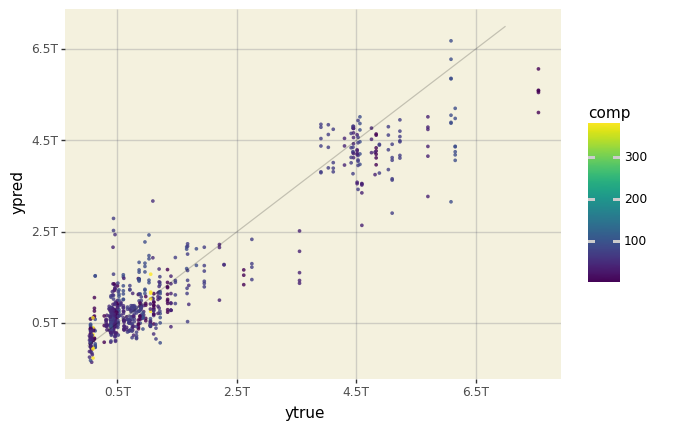

<ggplot: (8754661227314)>

In [ ]:
plot(X_test,y_test ,test_idx)

We see that even though our model had overfit the training set, the test set performance is not too bad, specially on when looking at highly compressed countries like `Russia` and `China`. We do see poor performance for China (top right corner) where our model is under-predicting the GDP values.

But for `Russia` (lower left yellow dots), it seems that the model is performing better than expected.

Now let's directly look at the predictions colored by the country.

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


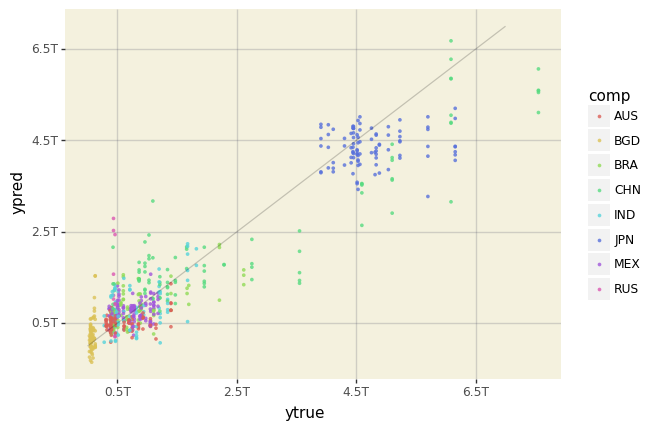

<ggplot: (-9223363282193393436)>

In [ ]:
plotcomp(X_test,y_test ,code[test_idx])

Now Let's move to year.

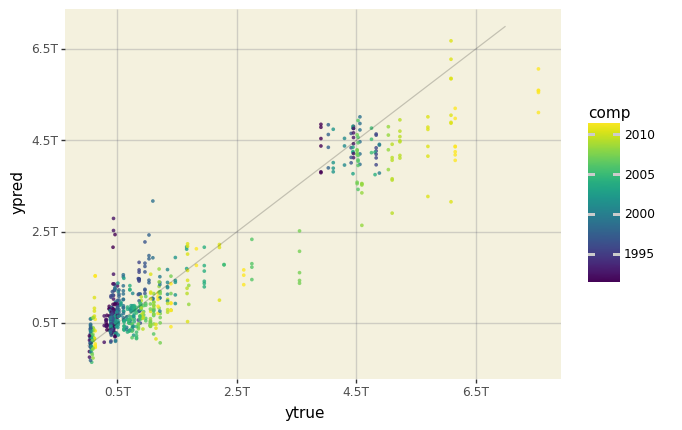

<ggplot: (8754661244087)>

In [ ]:
plotcomp(X_test,y_test ,years[test_idx])

### Next Steps

Next steps for us would be 
1. To reduce overfitting
2. To reduce impact of Compression (resizing)
3. To perform Shapley Analysis of the model
4. Subnational test dataset


Appendix:

#### How to handle different sized images

1. [SemScholar](https://www.semanticscholar.org/paper/Attention-to-Scale%3A-Scale-Aware-Semantic-Image-Chen-Yang/9f48616039cb21903132528c0be5348b3019db50?p2df)
  - We can feed the same image multiple times to the network, but with varying scales each time, and then take the average of the results.
  - This might only work if we start with images of the same aspect ratio, which would defeat the purpose.

2. [Arxiv](https://arxiv.org/pdf/1411.4038.pdf)
  - We could make the network fully-convolutional, meaning it has convolutional, max-pooling, and batch normalization layers all of which are invariant to the size of the image.

3. [StackExch](https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction)
  - Resize the images to the size of the smallest images (OpenCV, PIL), but we would lose some details.
  - Alternatively, we could pad the images of unequal sizes to a desired size, but resizing images is simpler.

4. [StackExch](https://stats.stackexchange.com/questions/250258/can-a-convolutional-neural-network-take-as-input-images-of-different-sizes)
  - Im2markup and other architectures do not assume that all images have the same dimension.

5. [Arxiv](https://arxiv.org/abs/1312.4400)
  - Pool the output of the last convolutional layer in a way that yields a fixed size array.

6. [Medium](https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89)
  -Explains why upscaling is a worse solution to down scaling
What if we downed scaled large images and upscaled small images


- Global Max-Pooling
- Padding to a certain size

w/ Keras:
-Will not be able to flatten layers. Will need GlobalMaxPooling2D or GlobalAveragePooling2D. (adaptivemaxpool2d) -> fastai
    -Can not put different sizes in a single numpy array.
   	 -This means we will
   		 1) Resize groups of the same size without big variations to ease training
   		 2) Do not resize and train images one by one
   		 3) Keep aspect ratio and pad sides of images.
   			 -May be easier since we are looking at light intensities.